## structure type _ 7cat _ unbalanced _ lr = 3e-4 _ 30 epochs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Any, Collection, Dict, List, Optional, Tuple, Union
from numpy.typing import ArrayLike
from fastcore.all import L
import pycm

In [3]:
def evaluate_classification(
    y_true: ArrayLike,
    y_pred: ArrayLike,
) -> Dict[str, Any]:
    """Evaluate a classification task.

    Args:
        y_true (ArrayLike): The true labels.
        y_pred (ArrayLike): The predicted labels.

    Returns:
        Dict[str, Any]: A dictionary of metrics.
    """
    might_have_rounded_floats = False
    assert len(y_true) == len(y_pred), "y_true and y_pred must be the same length."
    y_true = L([int(x) for x in y_true])

    y_pred_new = []
    int_indices = []
    for i, x in enumerate(y_pred):
        try:
            x_int = int(x)
            if x_int != x:
                might_have_rounded_floats = True
                logger.warning("y_pred contains rounded floats.")
            y_pred_new.append(x_int)
            int_indices.append(i)
        except Exception as e:
            y_pred_new.append(None)
    y_pred_new = L(y_pred_new)

    frac_valid = len(int_indices) / len(y_true)
    if len(int_indices) == 0:
        logger.warning("No valid predictions found.")
        y_pred_valid = L([None] * len(y_true))
        y_true_valid = y_true

    else:
        y_true_valid = y_true[int_indices]
        y_pred_valid = y_pred_new[int_indices]

    cm = pycm.ConfusionMatrix(list(y_true_valid), list(y_pred_valid))
    return {
        "accuracy": cm.Overall_ACC,
        "acc_macro": cm.ACC_Macro,
        "racc": cm.Overall_RACC,
        "kappa": cm.Kappa,
        "confusion_matrix": cm,
        "f1_macro": cm.F1_Macro,
        "f1_micro": cm.F1_Micro,
        "frac_valid": frac_valid,
        "all_y_true": y_true,
        "all_y_pred": y_pred,
        "valid_indices": int_indices,
        "might_have_rounded_floats": might_have_rounded_floats,
    }

In [4]:
from glob import glob
from fastcore.xtras import load_pickle
import os 
import pandas as pd
from sklearn import metrics

import matplotlib.pyplot as plt 
import matplotlib as mpl
#import seaborn as sns
import numpy as np 

from scipy.stats import sem
from scipy.constants import golden
ONE_COL_WIDTH_INCH = 3.25
TWO_COL_WIDTH_INCH = 7.2

ONE_COL_GOLDEN_RATIO_HEIGHT_INCH = ONE_COL_WIDTH_INCH / golden
TWO_COL_GOLDEN_RATIO_HEIGHT_INCH = TWO_COL_WIDTH_INCH / golden

import sys

sys.path.append("/mnt/c/Users/44907688G/Documents/home_vicky/LLMs_models/gptchem-gptj/plotutils/")
from plotutils import *

plt.style.use("/mnt/c/Users/44907688G/Documents/home_vicky/LLMs_models/gptchem-gptj/plotutils/kevin.mplstyle")

import matplotx

In [5]:
all_res = glob(f"./*.pkl")
print(f"Pickles found: {len(all_res)}")

Pickles found: 12


### ADJUST dictionary according to experiment

In [6]:
all_res

['./20240618-013914_600_44_predictions.pkl',
 './20240618-013940_600_43_predictions.pkl',
 './20240618-023908_1000_44_predictions.pkl',
 './20240618-024010_1000_43_predictions.pkl',
 './20240618-033944_1400_43_predictions.pkl',
 './20240618-044554_1800_43_predictions.pkl',
 './20240618-052804_600_42_predictions.pkl',
 './20240618-063401_1000_42_predictions.pkl',
 './20240618-063708_1400_44_predictions.pkl',
 './20240618-074255_1800_44_predictions.pkl',
 './20240618-083019_1400_42_predictions.pkl',
 './20240618-104537_1800_42_predictions.pkl']

In [7]:
compiled_res_list = []
conf_mats = []

for res in all_res:
    res = load_pickle(res)
    nan_prediction_mask = np.isnan(res["predictions"])
    error_prediction_mask = np.ma.masked_greater(res["predictions"][~nan_prediction_mask], 6)
    if len(np.ma.getmaskarray(res["predictions"][~nan_prediction_mask][~error_prediction_mask.mask])) == 1:
        error_prediction_mask = np.ma.getmaskarray(res["predictions"][~nan_prediction_mask][~error_prediction_mask.mask])[0]
    else:
        error_prediction_mask = error_prediction_mask.mask
    try:
        results = evaluate_classification(res["targets"][~error_prediction_mask], 
                                          res["predictions"][~nan_prediction_mask][~error_prediction_mask])
    except:
        results = evaluate_classification(res["true"][~error_prediction_mask], 
                                          res["predictions"][~nan_prediction_mask][~error_prediction_mask])
    summary = {
        'train_size': res['train_size'],
        'accuracy': results['accuracy'],
        'acc_macro': results['acc_macro'],
        'racc': results['racc'],
        'kappa': results['kappa'],
        'f1_macro': results['f1_macro'],
        'f1_micro': results['f1_micro'],
        'frac_valid': results['frac_valid'],
        'valid_indices': results['valid_indices'],
        'might_have_rounded_floats': results['might_have_rounded_floats'],
    }
    
    confusion_matrix = {
        'all_y_true': results['all_y_true'],
        'all_y_pred': results['all_y_pred']
    }
    
    conf_mats.append(confusion_matrix)
    compiled_res_list.append(summary)

In [8]:
compiled_res = pd.DataFrame(compiled_res_list)

In [9]:
compiled_res = compiled_res.sort_values(['train_size']).iloc[:, 0:8]
compiled_res

,train_size,accuracy,acc_macro,racc,kappa,f1_macro,f1_micro,frac_valid
0,600,0.82,0.948571,0.3252,0.733254,0.563474,0.82,1.0
1,600,0.84,0.954286,0.3264,0.762470,0.611033,0.84,1.0
6,600,0.84,0.954286,0.3193,0.764948,0.561272,0.84,1.0
2,1000,0.88,0.965714,0.3070,0.826840,0.767870,0.88,1.0
3,1000,0.89,0.968571,0.3180,0.838710,0.666690,0.89,1.0
7,1000,0.87,0.962857,0.3207,0.808627,0.648836,0.87,1.0
4,1400,0.96,0.988571,0.3156,0.941555,0.901299,0.96,1.0
8,1400,0.96,0.988571,0.3125,0.941818,0.889062,0.96,1.0
10,1400,0.86,0.960000,0.3155,0.795471,0.628718,0.86,1.0
5,1800,0.95,0.985714,0.3219,0.926265,0.896017,0.95,1.0


### ADJUST columns according to grouping

In [10]:
grouped_res = compiled_res.groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy           acc_macro                racc            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
600         0.833333  0.006667  0.952381  0.001905  0.323633  0.002194   
1000        0.880000  0.005774  0.965714  0.001650  0.315233  0.004190   
1400        0.926667  0.033333  0.979048  0.009524  0.314533  0.001017   
1800        0.943333  0.003333  0.983810  0.000952  0.321100  0.001060   

               kappa            f1_macro            f1_micro            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
600         0.753557  0.010177  0.578593  0.016232  0.833333  0.006667   
1000        0.824725  0.008748  0.694465  0.037063  0.880000  0.005774   
1400        0.892948  0.048738  0.806360  0.088891  0.926667  0.033333   
1800        0.916537  0.004865  0.855409  0.022009  0.943333  0.003333   

           frac_valid       
                 mean  sem  
train_size                  
600               1.0  0.0  
1000              1.0  0.0  
1400              1.0  0.0  
1800              1.0  0.0

[[0.78787879 0.         0.06060606 0.         0.03030303 0.
  0.12121212]
 [0.         0.92156863 0.         0.         0.         0.07843137
  0.        ]
 [0.         0.         0.93333333 0.         0.         0.06666667
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.33333333 0.         0.66666667 0.
  0.        ]
 [0.         0.         0.         0.         0.08333333 0.91666667
  0.        ]
 [0.         0.         0.03703704 0.         0.         0.03703704
  0.92592593]]
accuracy: 0.878862858274623


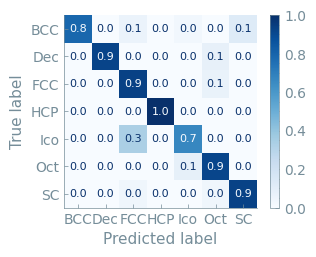

In [11]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]
confusion_matrix_max = []
for index, _ in enumerate(conf_mats_max):
    try:
        preds = conf_mats_max[index]
        actual = preds["all_y_true"]
        predicted = preds["all_y_pred"]
        confusion_matrix = metrics.confusion_matrix(actual, predicted)
        confusion_matrix_max.append(confusion_matrix)
    except Exception as e:
        print(e)
divisor = [[sum(sum(confusion_matrix_max)[n])] for n in range(7)]
norm_confusion_matrix = sum(confusion_matrix_max)/divisor
print(norm_confusion_matrix)

acc1=0
for i in range(len(norm_confusion_matrix)):
    acc=norm_confusion_matrix[i][i]
    acc1=acc1+acc
acc=acc1/sum(sum(norm_confusion_matrix))

print(f'accuracy: {acc}')

plt.rcParams.update({'font.size': 8})
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = norm_confusion_matrix, display_labels = ['BCC', 'Dec', 'FCC', 'HCP', 'Ico', 'Oct', 'SC'])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".1f")
plt.savefig('classif_struct_type_confusionMatrix_7categ_unbalanced_30ep_size1800.pdf', bbox_inches='tight')

In [12]:
sizes = np.sort(compiled_res["train_size"].unique())
print(sizes)

[ 600 1000 1400 1800]


In [13]:
print(grouped_res.loc[np.sort(sizes), :]['accuracy'])

                mean       sem
train_size                    
600         0.833333  0.006667
1000        0.880000  0.005774
1400        0.926667  0.033333
1800        0.943333  0.003333


In [14]:
plt.style.use("/mnt/c/Users/44907688G/Documents/home_vicky/LLMs_models/gptchem-gptj/plotutils/kevin.mplstyle")

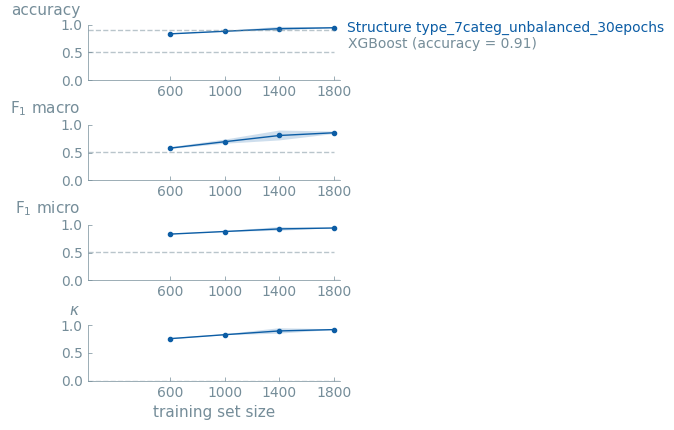

In [16]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

n_bins = 7
representations = ['7categ_unbalanced_30epochs']

for representation in representations:
    ax[0].plot(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['accuracy']['mean'],
        marker='o',
        label=f'Structure type_{representation}'
    )
    ax[0].fill_between(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['accuracy']['mean']
        -grouped_res.loc[sizes, :]['accuracy']['sem'],
        grouped_res.loc[sizes, :]['accuracy']['mean']
        +grouped_res.loc[sizes, :]['accuracy']['sem'],
        alpha = 0.2
    )
    
    ax[0].hlines(0.91, 0, 1800, linestyle='--', color='#758D99', alpha=0.5)
    ax[0].hlines(1, 0, 0, linestyle='--', color='#758D99', alpha=0.5)
    ax[0].hlines(0.51, 0, 1800, linestyle='--', color='#758D99', alpha=0.5)
    ax[0].hlines(0, 1800, 1840, linestyle='--', color='#758D99', alpha=0.5)
    ylabel_top('accuracy', ax=ax[0])
    ax[0].set_xticks(sizes)

    ax[1].plot(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['f1_macro']['mean'],
        marker='o',
        label=f'{representation}'
    )
    ax[1].fill_between(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['f1_macro']['mean']
        -grouped_res.loc[sizes, :]['f1_macro']['sem'],
        grouped_res.loc[sizes, :]['f1_macro']['mean']
        +grouped_res.loc[sizes, :]['f1_macro']['sem'],
        alpha=0.2
    )

    ax[1].hlines(1, 0, 0, linestyle='--', color='#758D99', alpha=0.5)
    ax[1].hlines(0.51, 0, 1800, linestyle='--', color='#758D99', alpha=0.5)
    ax[1].hlines(0, 1800, 1840, linestyle='--', color='#758D99', alpha=0.5)
    ylabel_top(r'F$_1$ macro', ax=ax[1])
    ax[1].set_xticks(sizes)

    ax[2].plot(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['f1_micro']['mean'],
        marker='o',
        label=f'{representation}'
    )

    ax[2].fill_between(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['f1_micro']['mean']
        -grouped_res.loc[sizes, :]['f1_micro']['sem'],
        grouped_res.loc[sizes, :]['f1_micro']['mean']
        +grouped_res.loc[sizes, :]['f1_micro']['sem'],
        alpha=0.2
    )

    ax[2].hlines(1, 0, 0, linestyle='--', color='#758D99', alpha=0.5)
    ax[2].hlines(0.51, 0, 1800, linestyle='--', color='#758D99', alpha=0.5)
    ax[2].hlines(0, 1800, 1840, linestyle='--', color='#758D99', alpha=0.5)
    ylabel_top(r'F$_1$ micro', ax=ax[2])
    ax[2].set_xticks(sizes)

    ax[3].plot(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['kappa']['mean'],
        marker='o',
        label=f'{representation}'
    )
    ax[3].fill_between(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['kappa']['mean']
        -grouped_res.loc[sizes, :]['kappa']['sem'],
        grouped_res.loc[sizes, :]['kappa']['mean']
        +grouped_res.loc[sizes, :]['kappa']['sem'],
        alpha=0.2
    )
    
    ax[3].hlines(1, 0, 0, linestyle='--', color='#758D99', alpha=0.5)
    ax[3].hlines(0, 0, 1800, linestyle='--', color='#758D99', alpha=0.5)
    ax[3].hlines(0, 1800, 1840, linestyle='--', color='#758D99', alpha=0.5)
    ylabel_top(r'$\kappa$', ax=ax[3])
    ax[3].set_xticks(sizes)

ax[-1].set_xlabel('training set size')
ax[0].text(1900, 0.58, 'XGBoost (accuracy = 0.91)')

matplotx.line_labels(ax[0])
plt.subplots_adjust(hspace=0.8, top=1, bottom=0.2)
fig.savefig('classif_structure_type_7categ_unbalanced_30ep_XGBoost.pdf', bbox_inches='tight')